In [ ]:
!pip install quantuminspire
!pip install qiskit

     |████████████████████████████████| 48 kB 2.3 MB/s 
     |████████████████████████████████| 207 kB 10.2 MB/s 
     |████████████████████████████████| 162 kB 46.1 MB/s 
  Created wheel for quantuminspire: filename=quantuminspire-1.7.0-py3-none-any.whl size=52132 sha256=946f80e20cc8fb0c6f86794c869aba6b2b723fd491218e4502774291a326ea48
  Stored in directory: /root/.cache/pip/wheels/74/ec/41/80206131a3a29080f7e3ffbe2958761deaf2a2985f180c2af3
  Created wheel for coreschema: filename=coreschema-0.0.4-py3-none-any.whl size=15029 sha256=5c0e3ee54c3be5263d5357774931db3a9c473fe9fec77f04ff3ce5788a53a5fd
  Stored in directory: /root/.cache/pip/wheels/29/28/77/73539fe0ce161da7a571cd8278a9296adbda257406bb6f100d
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=ea5d27bd23cdae9c2e092ddf79f209a673d7790f6171ee29303b8f9a71c81c2f
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built quantu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

ModuleNotFoundError: ignored

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/chest_xray copy-20220130T045607Z-001.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
# Concentrating on the first 100 samples
n_samples = 100

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)
# X_train = train_datagen.flow_from_directory("/content/chest_xray copy/train",
#                                                  target_size = (64, 64),
#                                                  batch_size = 32,
#                                                  class_mode = 'binary')

# transform = transforms.Compose([transforms.Resize(255),
#                                  transforms.CenterCrop(244),
#                                  transforms.ToTensor()])

transform = transforms.Compose(
                   [transforms.Resize((64,54)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


X_train = datasets.ImageFolder("/content/chest_xray copy/train", transform=transform)


# X_train = datasets.MNIST(root='./data', train=True, download=True,
#                          transform=transforms.Compose([transforms.ToTensor()]))

# # Leaving only labels 0 and 1 
# idx = np.append(np.where(X_train.normal_train == 0)[0][:n_samples], 
#                 np.where(X_train.pneumonia_train == 1)[0][:n_samples])

# idx = np.append(np.where(X_train['normal'], 1, 0))

# idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
#                 np.where(X_train.targets == 1)[0][:n_samples])

# # X_train.batch_size = X_train.batch_size[idx]
# # X_train.target_size = X_train.target_size[idx]

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# idx = np.append(np.where("/content/chest_xray copy/train/NORMAL" in X_train.targets.path())[0][:n_samples], 
#                 np.where("/content/chest_xray copy/train/PNEUMONIA" in X_train.targets.path())[0][:n_samples])

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [ ]:
a = np.arange(10)
# array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#np.where
print(np.append(np.where(a < 5, a, 10*a)))
#output
# array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

# Parameters
# conditionarray_like, bool
# Where True, yield x, otherwise yield y.

# x, y array_like
# Values from which to choose. x, y and condition need to be broadcastable to some shape.

# Returns
# outndarray
# An array with elements from x where condition is True, and elements from y elsewhere.

Normal


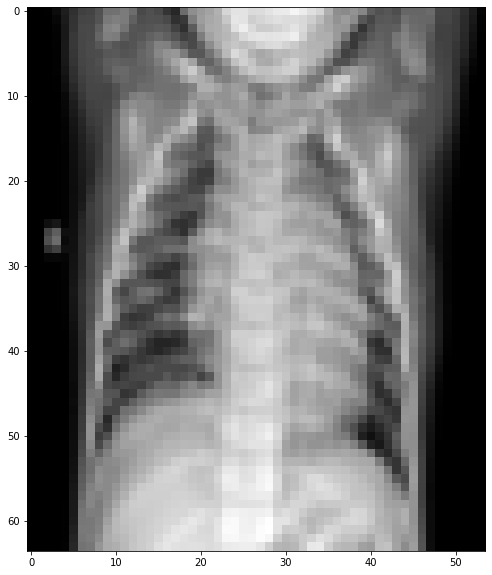

In [ ]:
from matplotlib.colors import Normalize
# n_samples_show = 6

# data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# while n_samples_show > 0:
# #     images, targets = data_iter.__next__()
#     axes[n_samples_show - 1].X_train(data[1, :].squeeze().copy(), cmap='gray')
# #     axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')

# #     # axes[n_samples_show - 1].set_xticks([])
# #     # axes[n_samples_show - 1].set_yticks([])
# #     # axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
#     n_samples_show -= 1

# Run this to test your data loader
images, labels = next(iter(train_loader))
# helper.imshow(images[0], normalize=False)
axes.imshow(images[:, 0, :].squeeze(), cmap="gray")


if str(labels[0].squeeze()) == "tensor(1)":
  print("Pnuemonia")
else:
  print("Normal")

In [ ]:
n_samples = 50

# test_datagen = ImageDataGenerator(rescale = 1./255)
# X_test = test_datagen.flow_from_directory("/content/chest_xray copy/test",
#                                             target_size = (64, 64),
#                                             batch_size = 32,
#                                             class_mode = 'binary')

X_test = datasets.ImageFolder("/content/chest_xray copy/test", transform=transform)

# X_test = datasets.MNIST(root='./data', train=False, download=True,
#                         transform=transforms.Compose([transforms.ToTensor()]))

# idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
#                 np.where(X_test.targets == 1)[0][:n_samples])

# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        #Line that is causing errors
        output = model(data.permute(1, 0, 2, 3))
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

RuntimeError: ignored

Text(0, 0.5, 'Neg Log Likelihood Loss')

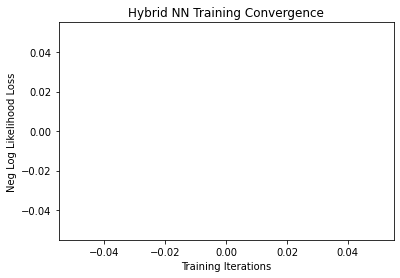

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data.unsqueeze())
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

TypeError: ignored

RuntimeError: ignored

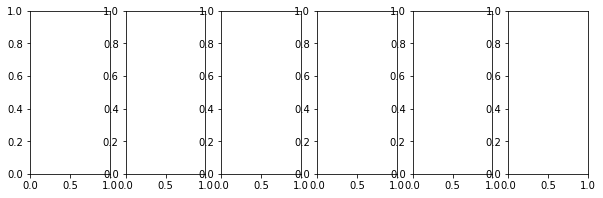

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1